# Beer Recommender System
This notebook implements data preprocessing and modeling techniques to create a beer recommender system. I

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


/Users/gustavnielsen/Documents/Comp_tools_project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing Functions
These functions clean the dataset by handling duplicates, missing values, and incorrect formats. They prepare the data for splitting and analysis.

In [3]:
def preprocess_data(df):
    df_filtered = df.drop_duplicates(["name", "reviewer", "review_text"]) # Remove duplicate entries
    print("Size after drop_duplicates: ", len(df_filtered))
    
    df_filtered['rating'] = pd.to_numeric(df_filtered['rating'], errors='coerce')  # Set erros to NaN
    df_filtered = df_filtered.dropna(subset=['rating'])  # Drop rows where 'rating' is NaN
    print("Size after drop rating NA: ", len(df_filtered))
    
    df_filtered['abv'] = pd.to_numeric(df_filtered['abv'].str.rstrip('%'), errors='coerce') 
    df_filtered = df_filtered.dropna(subset=['abv'])
    print("Size after drop abv NA: ", len(df_filtered))
    
    return df_filtered

def create_test_train(df, reviewer_col="reviewer", random_state=7, test_size=100, mask_percentage=0.10):
    """
    Splits a dataset into training and test sets, masking a portion of test set entries.
    
    Parameters:
    - df (pd.DataFrame): The dataset to split.
    - reviewer_col (str): The column name containing reviewer IDs.
    - random_state (int): The random state for reproducibility.
    - test_size (int): The number of reviewers to sample for the test set.
    - mask_percentage (float): The percentage of beers to mask for each reviewer in the test set.

    Returns:
    - df_train (pd.DataFrame): The training set.
    - df_test_masked (pd.DataFrame): The test set with masked entries.
    """
    # Randomly sample reviewers
    sampled_reviewers = df[reviewer_col].sample(n=test_size, random_state=random_state)
    
    # Get reviews from the sampled reviewers
    df_test = df[df[reviewer_col].isin(sampled_reviewers)]
    
    # Group by reviewer to get each user's beers
    df_test_grouped = df_test.groupby(reviewer_col)
    
    # Randomly mask a percentage of beers for each reviewer
    test_set_masked = []
    for reviewer, group in df_test_grouped:
        # Calculate how many beers to mask
        num_to_mask = max(int(len(group) * mask_percentage), 1)
        
        # Sample the calculated number of beers
        masked_group = group.sample(n=num_to_mask, random_state=random_state)
        test_set_masked.append(masked_group)
    
    # Combine masked reviews into a single DataFrame
    df_test_masked = pd.concat(test_set_masked)
    df_test_masked = df_test_masked[df_test_masked['rating'] > 3.5]
    # Remove masked reviews from the training data
    df_train = df.drop(df_test_masked.index)
    
    # Display dataset summaries
    print("\n### Dataset Summary ###")
    print(f"Total reviewers sampled: {len(sampled_reviewers)}")
    print(f"Training set size: {df_train.shape}")
    print(f"Test set size: {df_test_masked.shape}")
    
    return df_train, df_test_masked

In [4]:
# Load data and preprocess
df = pd.read_pickle('encoded_beers_SBERT.pkl')

df_filtered = preprocess_data(df)
del df

Size after drop_duplicates:  1157819


/var/folders/ql/h53w_qjs60509nsf4jbr01c00000gn/T/ipykernel_58814/4130808962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = pd.to_numeric(df_filtered['rating'], errors='coerce')  # Set erros to NaN


Size after drop rating NA:  1157807
Size after drop abv NA:  1154739


In [5]:
df_filtered.head()

,id,name,brewery,subgenre,abv,location,rating,average_rating,reviewer,review_date,review_text,algorithm_rating,total_reviews,sbert_embedding
0,1,Wild Dog Pale Ale,Wild Dog (Tiemann Beer),American Pale Ale,5.2,🇯🇪Jersey,3.5,2.99,Jerseyislandbeer,"December 14, 2023",330ml can from Shoprite in Livingstone. At hom...,28.0,11,"[0.037878353, 0.00593541, 0.0062317043, -0.011..."
1,2,Wild Dog Pale Ale,Wild Dog (Tiemann Beer),American Pale Ale,5.2,"🇬🇧Ipswich, England",3.2,2.99,Grumbo,"February 28, 2022","18/2/2022. Can sample courtesy of fonefan, che...",28.0,11,"[-0.037820198, -0.044825517, 0.07764052, 0.065..."
2,3,Wild Dog Pale Ale,Wild Dog (Tiemann Beer),American Pale Ale,5.2,"🇸🇪Tyresö, Sweden",3.5,2.99,omhper,"February 19, 2022","--Sample, thanks fonefan! -- Hazy deep golden,...",28.0,11,"[0.056960188, -0.00059301173, 0.11057871, 0.02..."
3,4,Wild Dog Pale Ale,Wild Dog (Tiemann Beer),American Pale Ale,5.2,"🇫🇮Vasa, Finland",2.8,2.99,oh6gdx,"January 31, 2022","Panda from a can, thanks fonefan!. Golden colo...",28.0,11,"[0.003549767, -0.010705345, 0.02083684, 0.0106..."
4,6,Wild Dog Pale Ale,Wild Dog (Tiemann Beer),American Pale Ale,5.2,"🇩🇰Haderslev, Denmark",2.6,2.99,martin00sr,"January 8, 2022","Can @Ulfborg. Cloudy amber, white head. Malty ...",28.0,11,"[-0.01005388, -0.02942978, 0.0016338513, 0.017..."


In [6]:
df_train, df_test_masked = create_test_train(df_filtered)


### Dataset Summary ###
Total reviewers sampled: 100
Training set size: (1151860, 14)
Test set size: (2879, 14)


In [8]:
# Create dataframe for retrieving beer information
beer_info = df_filtered[['name', 'abv', 'subgenre', 'average_rating']]

# Drop duplicate rows based on the 'name' column (i.e. beers)
beer_info = beer_info.drop_duplicates(subset='name')

beer_info.set_index('name', inplace=True)

### Create locality-sensitive hashing (LSH)

In [9]:
# Initialize a variable to store the model
sbert_model = None

def encode_sbert(query, model_name='sentence-transformers/all-MiniLM-L6-v2'):
    """
    Encodes a query using SBERT. Loads the model if not already loaded.
    
    Parameters:
        query (str or list of str): The query or list of queries to encode.
        model_name (str): The name of the SBERT model to load (default is 'all-MiniLM-L6-v2').
    
    Returns:
        numpy.ndarray: The embedding(s) for the input query/queries.
    """
    global sbert_model  # Use the global variable to store the model
    
    # Load the model if it's not already loaded
    if sbert_model is None:
        sbert_model = SentenceTransformer(model_name)
    
    # Encode the query and return the embeddings
    return sbert_model.encode(query)

def generate_hyperplanes(dim, num_hash_functions):
    """
    Generate random hyperplanes for hash functions.
    
    Parameters:
    - dim: Dimensionality of the embeddings.
    - num_hash_functions: Number of hash functions per table.
    
    Returns:
    - A matrix of shape (num_hash_functions, dim) where each row is a hyperplane.
    """
    return np.random.randn(num_hash_functions, dim)

def hash_vectors(vectors, hyperplanes):
    """
    Hash a batch of vectors using a set of hyperplanes.

    Parameters:
    - vectors: Input vectors (2D array of shape [n_samples, d]).
    - hyperplanes: Matrix of hyperplanes (2D array of shape [k, d]).

    Returns:
    - A matrix of binary hash values (shape [n_samples, k]).
    """
    # Compute dot products and return binary hash values
    return (np.dot(vectors, hyperplanes.T) > 0).astype(int)

class LSHVectorized:
    def __init__(self, d, k, L):
        """
        Initialize the LSH scheme with vectorized support.

        Parameters:
        - d: Dimensionality of the input vectors.
        - k: Number of hash functions per table.
        - L: Number of hash tables.
        """
        self.L = L
        self.tables = [defaultdict(list) for _ in range(L)]
        self.hyperplanes = [generate_hyperplanes(d, k) for _ in range(L)]

    def add_vectors(self, vectors, identifiers):
        """
        Add a batch of vectors to the LSH index.

        Parameters:
        - vectors: Input vectors (2D array of shape [n_samples, d]).
        - identifiers: A list of unique identifiers for the vectors.
        """
        for table, hyperplanes in zip(self.tables, self.hyperplanes):
            # Compute hash values for all vectors at once
            hash_values = hash_vectors(vectors, hyperplanes)
            
            # Convert binary hash values to tuples for dictionary keys
            hash_keys = [tuple(h) for h in hash_values]
            
            # Add vectors to their corresponding buckets
            for identifier, key in zip(identifiers, hash_keys):
                table[key].append(identifier)

    def query(self, vectors):
        """
        Query the LSH index to find similar items for a batch of vectors.

        Parameters:
        - vectors: Query vectors (2D array of shape [n_samples, d]).

        Returns:
        - A list of sets, where each set contains the candidates for a query vector.
        """
        candidates = [set() for _ in range(len(vectors))]
        for table, hyperplanes in zip(self.tables, self.hyperplanes):
            # Compute hash values for all query vectors
            hash_values = hash_vectors(vectors, hyperplanes)
            
            # Convert binary hash values to tuples for dictionary keys
            hash_keys = [tuple(h) for h in hash_values]
            
            # Retrieve candidates for each query
            for i, key in enumerate(hash_keys):
                candidates[i].update(table.get(key, []))
        return candidates

In [10]:
vectors = np.vstack(df_train["sbert_embedding"].values)  # Combine embeddings into a 2D array
identifiers = df_train.index.tolist()  # Use review IDs as identifiers

In [11]:
## Run LSH ##
# Initialize LSH scheme
d = 384
k = 13
L = 30

lsh = LSHVectorized(d, k, L)

In [12]:
# Add vectors to the LSH index
lsh.add_vectors(vectors, identifiers)

### Create Collaborative Filtering (CF)

In [13]:

def predict_ratings_user_based(user_item_matrix, similarity_matrix):
   
    """
    this function predicts the ratings for the user_item_matrix using the similarity_matrix
    

    Parameters: 
    
    - user_item_matrix (DataFrame): User-item matrix with ratings centered around the user mean.
    - similarity_matrix (DataFrame): User-user similarity matrix.
    
    Returns:
        - pred (DataFrame): Predicted ratings for all user-item pairs.
    
    """


    # Compute predictions
    similarity_sum = np.abs(similarity_matrix).sum(axis=1)[:, None]
    pred = np.dot(similarity_matrix, user_item_matrix) / (similarity_sum + 1e-8)



    return pred


def collaborative_filtering(df):
    
    """
    Predicts user ratings for items using user-based collaborative filtering with cosine similarity. 
    Preprocesses the input data to create a centered user-item matrix, computes user similarities, 
    and generates predicted ratings.

    Parameters:
    - df (DataFrame): Input data with 'reviewer', 'name', and 'rating' columns.

    Returns:
    - pr_df (DataFrame): Predicted ratings for all user-item pairs.

    """


    user_item_matrix = df.pivot_table(
    index="reviewer",     # Rows: Reviewers
    columns="name",       # Columns: Beer names
    values="rating",      # Values: Ratings
    fill_value=0          # Fill missing ratings with 0
    )
    
    user_item_np = np.where(user_item_matrix != 0, (user_item_matrix - 3) / 2, 0) # scale to [-1,1]
    user_item_matrix = pd.DataFrame(user_item_np, index=user_item_matrix.index, columns=user_item_matrix.columns)


    # Compute cosine similarity
    cosine_similarity_matrix = cosine_similarity(user_item_matrix)
    
    # Predict ratings
    predicted_ratings = predict_ratings_user_based(user_item_matrix, cosine_similarity_matrix)

    df_out = pd.DataFrame(predicted_ratings, index=user_item_matrix.index, columns=user_item_matrix.columns)
   
    return df_out


collab_df = collaborative_filtering(df_train)

In [14]:
# Create user-beer matrix to find reviews per user
user_beer_matrix = df_train.pivot_table(
    index="reviewer",     # Rows: Reviewers
    columns="name",       # Columns: Beer names
    values="rating",      # Values: Ratings
    fill_value=0          # Fill missing ratings with 0
    )

In [15]:
n_reviews = np.sum(user_beer_matrix > 0, axis=1)
beta = 0.55 + ((0.45) / (1+np.log(n_reviews))) # Describe how much weight to put on collaborative filtering (1-beta), so more weight is on users with many reviews

### Review Term Explanations:

In [77]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import CountVectorizer

# Define reference context for flavor-related words. The first 20 is from a aromatic kit used for sommeliers, the rest is ai-generated.
context_words = [
    "bitter", "sweet", "salt", "sour", "umami",
    "lemon", "grapefruit", "apple", "pear", "blackcurrant", "prune", "melon", 
    "banana", "acacia", "rose", "cut grass", "hay", "bay leaf", "thyme", 
    "tomato", "pepper", "nutmeg", "clove", "bread", "butter", "vanilla", 
    "hazelnut", "toast", "malt", "caramel", "honey", "coffee", "licorice",
    "pine", "grass", "resin", "floral", "perfume", "incense", "cinnamon",
    "ginger", "anise", "nut", "almond", "walnut", "chestnut", "peanut",
    "soy", "mushroom", "earth", "dust", "wood", "barnyard", "horse",
    "wet", "dry", "metallic", "sulfur", "fish", "cheese", "butter",
    "cream", "leather", "silk", "rubber", "barnyard", "ammonia",
    "rotten", "acid"
]
custom_stop_words = ["beer", "beers", "bottle", "taste", "nice", "aroma", "like", "good", "great", "head", "flavor", "flavors", "flavour", "flavours", "brew", "can"]
context_embeddings = encode_sbert(context_words)

# Function to filter terms dynamically
def is_flavor_related(term, context_embeddings, threshold=0.35):
    term_embedding = sbert_model.encode([term])[0]
    cosine_similarity = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    max_similarity = max(cosine_similarity(term_embedding, context) for context in context_embeddings)
    return max_similarity > threshold

def plot_bucket(bucket_vectors, cluster_labels, perplexity=30, n_iter=5000, learning_rate=200):
    """
    Visualizes differences within an LSH bucket using t-SNE with configurable parameters.
    
    Args:
        bucket_vectors (np.ndarray): High-dimensional vectors of items in the bucket.
        cluster_labels (np.ndarray): Cluster labels assigned to each vector.
        perplexity (int): The t-SNE perplexity parameter, balancing local/global data views.
        n_iter (int): Number of iterations for t-SNE optimization.
        learning_rate (float): Learning rate for t-SNE optimization.
    """
    # t-SNE reducer with tuned parameters
    reducer = TSNE(
        n_components=2, 
        random_state=42, 
        perplexity=perplexity, 
        n_iter=n_iter, 
        learning_rate=learning_rate
    )
    reduced_vectors = reducer.fit_transform(bucket_vectors)
    
    # Plotting
    plt.figure(figsize=(16, 10))
    scatter = plt.scatter(
        reduced_vectors[:, 0],
        reduced_vectors[:, 1],
        c=cluster_labels,  # Color points by cluster labels
        cmap='plasma',     # Colormap for the scatter plot
        alpha=0.7          # Transparency for better visualization
    )
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(f"t-SNE Visualization (Perplexity={perplexity}, n_iter={n_iter}, LR={learning_rate})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(alpha=0.3)
    plt.show()

def getThemes(df_filtered, beer_name, query_embedding, limit=100):
    # Initialize CountVectorizer with custom stopwords
    default_stop_words = CountVectorizer(stop_words='english').get_stop_words()
    all_stop_words = list(set(default_stop_words).union(custom_stop_words))

    # Pass the combined stop words to CountVectorizer
    vectorizer = CountVectorizer(max_features=100, stop_words=all_stop_words, token_pattern=r'\b[a-zA-Z]{2,}\b')
    df_beer = df_filtered[df_filtered["name"] == beer_name]
    # Extract top terms from cluster reviews
    term_matrix = vectorizer.fit_transform(df_beer["review_text"])
    terms = vectorizer.get_feature_names_out()
    term_counts = np.array(term_matrix.sum(axis=0)).flatten()
    top_terms = [terms[i] for i in term_counts.argsort()[-limit:]]  # Top 5 terms
    filtered_top_terms = [term for term in top_terms if is_flavor_related(term, context_embeddings)]
    
    # Return the terms most similar to the query
    term_embeddings = np.vstack([encode_sbert(term) for term in filtered_top_terms])
    
    # Calculate cosine similarity between query and terms
    similarities = cosine_similarity(query_embedding, term_embeddings)[0]
    
    # Create a DataFrame to store terms and their similarities
    term_similarity_df = pd.DataFrame({
        'term': filtered_top_terms,
        'similarity': similarities
    })
    
    # Sort terms by similarity to the query
    term_similarity_df = term_similarity_df.sort_values(by='similarity', ascending=False)
    
    # Return the top similar themes
    return term_similarity_df['term'].head(10).tolist()


## Make reccomendations

**Full pipeline setup**

In [78]:
def recommend_beer_A(query_embedding, df_train, user_name, beer_info, beta, abv_desired=None, style_desired=None, n_clusters=5, notes = False, plot = False):
    # Query the LSH index
    candidates = lsh.query(query_embedding)
    # Filter bucket vectors and metadata
    bucket_data = df_train[df_train["id"].isin(list(candidates[0]))]
    bucket_vectors = np.vstack(bucket_data["sbert_embedding"].to_numpy())
    
    # Extract subgenre information
    subgenres = bucket_data["subgenre"].values  # Adjust column name as necessary

    # Perform clustering on bucket vectors
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=7)
    cluster_labels = kmeans.fit_predict(bucket_vectors)
    
    # Assign query to the nearest cluster
    query_cluster = kmeans.predict(query_embedding)[0]

    # Filter beers in the same cluster as the query
    cluster_indices = np.where(cluster_labels == query_cluster)[0]
    cluster_vectors = bucket_vectors[cluster_indices]
    cluster_beers = bucket_data.iloc[cluster_indices]
    # Compute similarities within the selected cluster
    sims = cosine_similarity(query_embedding, cluster_vectors)[0]
    
    beer_LSH = pd.DataFrame({
        'similarity': sims,
        'beer': cluster_beers["name"].values,  # Adjust column name if necessary
    })
    
    LSH_score = beer_LSH.groupby('beer')['similarity'].mean()

    # Perform collaborative 
    try:
        predcicted_rating_user = collab_df.loc[user_name]
        collab_filtering_scores = predcicted_rating_user[LSH_score.index.tolist()] # Get CF_score for user for the beers in cluster
        collab_values = collab_filtering_scores.values
        beta = beta[user_name]
    except KeyError:
        collab_filtering_scores = 0
        collab_values = 0
        beta = 1


    # Penalise difference in abv by using a nonlinear function penalising greater differences more
    abv = beer_info.loc[LSH_score.index.tolist()]["abv"]

    alpha = 0.05
    if abv_desired:
        if abv_desired == 0:
            abv_weight = -2 * abs(abv - abv_desired)
        else:
            abv_weight = -alpha * ((abv - abv_desired)**2) / (abv_desired**1.5 + 1)
        abv_diff = abs(abv.values - abv_desired)
    else:
        abv_weight = abv - abv
        abv_diff = 0
    
    # Add bonus for match in style
    style_bonus = np.zeros(len(LSH_score))
    if style_desired:
        relevant_styles = beer_info.loc[LSH_score.index.tolist()]["subgenre"]
        style_mask = relevant_styles == style_desired
        style_bonus[style_mask] = 0.05
    if plot:
        plot_bucket(bucket_vectors=bucket_vectors , cluster_labels=cluster_labels, perplexity=30, n_iter=5000, learning_rate=200)
    # Combine weights and scores
    weighted_score = (
        beta * LSH_score +
        (1-beta) * collab_filtering_scores +
        abv_weight +
        style_bonus
    )

    # Create final DataFrame
    beer_weighted_score = pd.DataFrame({
        'beer': LSH_score.index,
        'score': weighted_score,
        'abv': abv.values,
        'LSH_score': LSH_score.values,
        'LSH_score_weighted': LSH_score.values * beta,
        'collab_score': collab_values,
        'collab_score_weighted': collab_values * (1-beta),
        'abv_diff': abv_diff,
        'abv_weight': abv_weight.values,
        'Style bonus': style_bonus,
        'Weight beta': beta
    })
    
    # Remove index of weighted score and keep the beer name as a column
    beer_weighted_score.reset_index(drop=True, inplace=True)
    
    # Get the 10 beers with the highest weighted scores
    beer_weighted_score = beer_weighted_score.sort_values(by='score', ascending=False)
    if notes:
        # Remove index of weighted score and keep the beer name as a column
        beer_weighted_score.reset_index(drop=True, inplace=True)
        
        # Get the 10 beers with the highest weighted scores
        beer_weighted_score = beer_weighted_score.sort_values(by='score', ascending=False).head(10)
        
        # Apply getThemes to each beer in the DataFrame
        beer_weighted_score['notes'] = beer_weighted_score['beer'].apply(lambda x: getThemes(df_train, x, query_embedding))

    return beer_weighted_score.sort_values(by='score', ascending=False)

    

/Users/gustavnielsen/Documents/Comp_tools_project/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


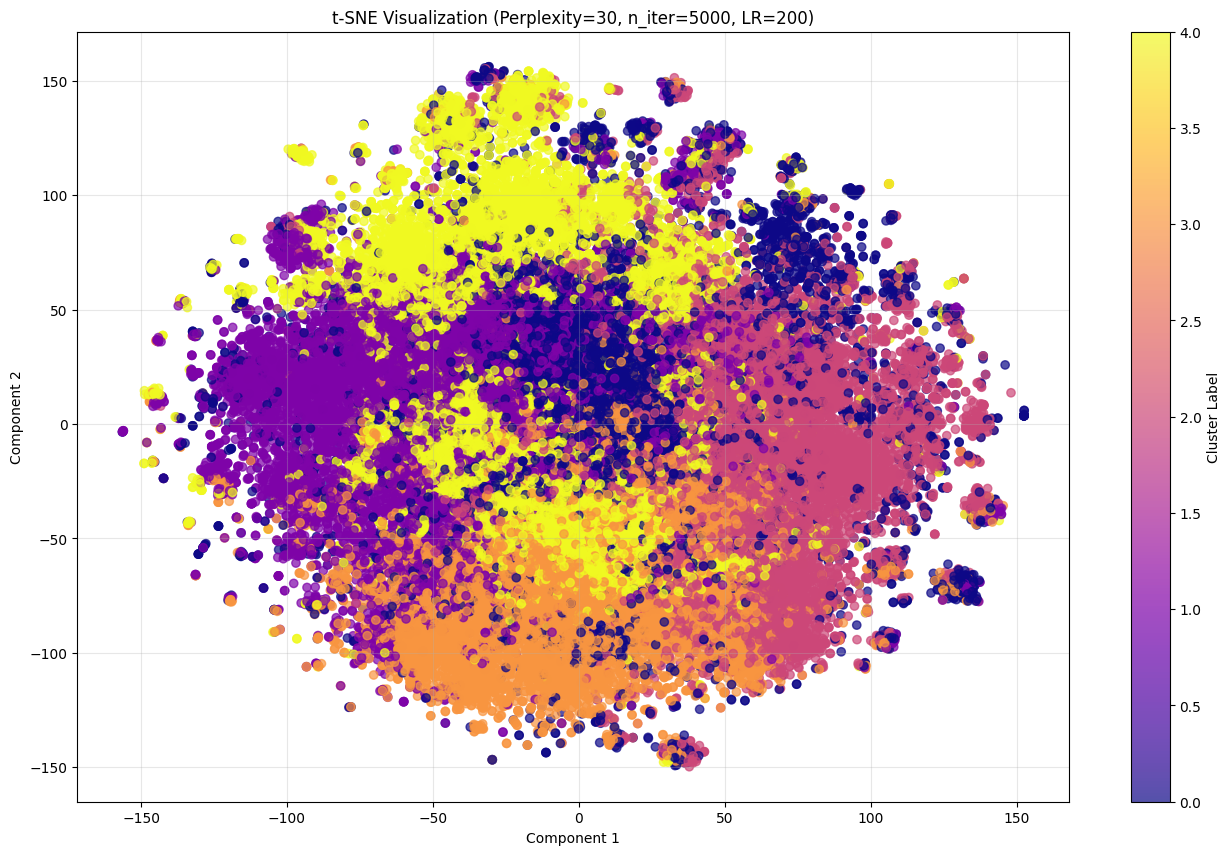

Top 5 recommended beers:


,beer,score,abv,LSH_score,LSH_score_weighted,collab_score,collab_score_weighted,abv_diff,abv_weight,Style bonus,Weight beta,notes
0,Colorado Appia,0.455101,5.5,0.753219,0.460936,-0.000183,-0.000071,1.5,-0.005763,0.0,0.611954,"[orange, tasting, bitter, citrus, citrusy, sweetness, ale, bitterness, drinkability, spicy]"
1,3 Fonteinen Zenne y Frontera - Oloroso & Pedro Ximénez Blend (Season 17|18 Blend No. 50),0.448827,6.9,0.731065,0.447379,0.003799,0.001474,0.1,-0.000026,0.0,0.611954,"[orange, tasting, bitter, citrus, sour, sourness, tastes, acidic, fruity, lemon]"
2,Kemker Mia X Lambic,0.445701,4.5,0.754231,0.461555,0.000400,0.000155,2.5,-0.016009,0.0,0.611954,"[orange, bitter, citrus, bitterness, beerfest, sour, bland, grapes, fruit, spicy]"
3,Sovina Amber,0.443296,6.0,0.728468,0.445789,0.000175,0.000068,1.0,-0.002561,0.0,0.611954,"[orange, bitter, citrus, sweetness, bitterness, sour, sourish, fruit, acidic, fizzy]"
4,Whiplash Cream on Chrome,0.437828,8.0,0.718281,0.439555,0.002150,0.000834,1.0,-0.002561,0.0,0.611954,"[orange, tasting, bitter, citrus, citrusy, sweetness, alcohol, bitterness, grapefruit, bright]"
5,Bird Fuut Fieuw,0.432724,4.6,0.729886,0.446657,0.002117,0.000821,2.4,-0.014754,0.0,0.611954,"[orange, bitter, citrus, sweetness, ipa, ale, beerwulf, bitterness, grapefruit, fruit]"
6,To Øl Tangerine Cream,0.432297,4.6,0.728646,0.445898,0.002972,0.001153,2.4,-0.014754,0.0,0.611954,"[orange, oranges, bitter, citrus, citrusy, sweetness, ale, drink, bitterness, grapefruit]"
7,Maisel & Friends Bavaria Ale,0.431891,6.1,0.709044,0.433903,0.000164,0.000064,0.9,-0.002075,0.0,0.611954,"[orange, bitter, citrus, bitterness, beery, sour, tastes, fruit, spicy, phenolic]"
8,De Proefbrouwerij / Hair of the Dog Flanders Fred,0.422038,7.5,0.682311,0.417543,0.013232,0.005135,0.5,-0.000640,0.0,0.611954,"[orange, bitter, citrus, sweetness, ale, wine, bitterness, aromas, sour, sourness]"
9,Almanac Hoppy Sour: Citra,0.419056,6.8,0.676005,0.413685,0.014106,0.005474,0.2,-0.000102,0.0,0.611954,"[orange, bitter, citrus, citrusy, sweetness, ale, wine, bitterness, grapefruit, aromas]"


In [79]:
#Example
# Create a query
test_query = "Light, refreshing bitter beer with a orange taste"
user_name = "shoulderbroken"
query_embedding = encode_sbert(test_query).reshape(1, -1)
beer_recommendations= recommend_beer_A(query_embedding, df_train, user_name, beer_info, beta, abv_desired=7, notes=True, plot=True)

print("Top 5 recommended beers:")
# Set max column width to display full array
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
display(beer_recommendations.head(10))

### Evaluation of experiment B short pipeline without KMEANS

In [29]:
def recommend_beer_B(query_embedding, df_train, user_name, beer_info, beta, abv_desired=None, style_desired=None, n_clusters=5):
    # Query the LSH index
    candidates = lsh.query(query_embedding)
    # Filter bucket vectors and metadata
    bucket_data = df_train[df_train["id"].isin(list(candidates[0]))]
    bucket_vectors = np.vstack(bucket_data["sbert_embedding"].to_numpy())
    
    # Extract subgenre information
    subgenres = bucket_data["subgenre"].values 
    
    # Compute similarities within the selected cluster
    sims = cosine_similarity(query_embedding, bucket_vectors)[0]
    
    beer_LSH = pd.DataFrame({
        'similarity': sims,
        'beer': df_train[df_train["id"].isin(list(candidates[0]))]["name"].values,
    })
    
    LSH_score = beer_LSH.groupby('beer')['similarity'].mean()
    
    # Perform collaborative 
    try:
        predcicted_rating_user = collab_df.loc[user_name]
        collab_filtering_scores = predcicted_rating_user[LSH_score.index.tolist()] # Get CF_score for user for the beers in cluster
        collab_values = collab_filtering_scores.values
        beta = beta[user_name]
    except KeyError:
        collab_filtering_scores = 0
        collab_values = 0
        beta = 1

    # Penalise difference in abv by using a nonlinear function penalising greater differences more
    abv = beer_info.loc[LSH_score.index.tolist()]["abv"]

    alpha = 0.05
    if abv_desired:
        if abv_desired == 0:
            abv_weight = -2 * abs(abv - abv_desired)
        else:
            abv_weight = -alpha * ((abv - abv_desired)**2) / (abv_desired**1.5 + 1)
        abv_diff = abs(abv.values - abv_desired)
    else:
        abv_weight = abv-abv
        abv_diff = 0
   
    
    # Add bonus for match in style
    style_bonus = np.zeros(len(LSH_score))
    if style_desired:
        relevant_styles = beer_info.loc[LSH_score.index.tolist()]["subgenre"]
        style_mask = relevant_styles == style_desired
        style_bonus[style_mask] = 0.05
    
    
    # Combine weights and scores
    weighted_score = (
        beta * LSH_score +
        (1-beta) * collab_filtering_scores +
        abv_weight +
        style_bonus
    )

    # Create final DataFrame
    beer_weighted_score = pd.DataFrame({
        'beer': LSH_score.index,
        'score': weighted_score,
        'abv': abv.values,
        'LSH_score': LSH_score.values,
        'LSH_score_weighted': LSH_score.values * beta,
        'collab_score': collab_values,
        'collab_score_weighted': collab_values * (1-beta),
        'abv_diff': abv_diff,
        'abv_weight': abv_weight.values,
        'Style bonus': style_bonus,
        'Weight beta': beta
    })
    
    # Remove index of weighted score and keep the beer name as a column
    beer_weighted_score.reset_index(drop=True, inplace=True)

    return beer_weighted_score.sort_values(by='score', ascending=False)

    

**Full Cosine Similarity Model**

In [30]:
# Reccomendation using only cosine similarity
def recommend_beer_C(query_embedding, df_train, vectors):

    # Compute similarities within the selected cluster
    sims = cosine_similarity(query_embedding, vectors)[0]
    
    beer_LSH = pd.DataFrame({
        'similarity': sims,
        'beer': df_train["name"].values,
    })
    
    cosine_score = beer_LSH.groupby('beer')['similarity'].mean()

    # Create final DataFrame
    beer_weighted_score = pd.DataFrame({
        'beer': cosine_score.index,
        'cosine_score': cosine_score.values,
    })

    return beer_weighted_score.sort_values(by='cosine_score', ascending=False)

**Only collaborative filtering setup**

In [32]:
# Reccomend beer just using collaborative filtering
def recommend_beer_D(user_name):
    # Perform collaborative filtering
    predcicted_rating_user = collab_df.loc[user_name]
    
    # Create final DataFrame
    beer_weighted_score = pd.DataFrame({
        'beer': predcicted_rating_user.index,
        'collab_score': predcicted_rating_user.values,
    })

    return beer_weighted_score.sort_values(by='collab_score', ascending=False)

### Evaluation runs for each of the 4 setups

In [48]:
import time
# Reccomender_A without abv and style info
num_true_A = 0
num_false_A = 0
total_time_A = 0.0
times_A = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    beer_recommendations= recommend_beer_A(query_embedding=query, df_train=df_train, user_name=user, beer_info=beer_info, beta=beta, abv_desired=None, style_desired=None)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_A += elapsed_time
    times_A.append(elapsed_time)
    
    if real_beer in beer_recommendations["beer"].head(20).tolist():
        num_true_A += 1
    else:
        num_false_A +=1

In [49]:
# Reccomender_B without abv and style info
num_true_B = 0
num_false_B = 0
total_time_B = 0.0
times_B = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    beer_recommendations= recommend_beer_B(query_embedding=query, df_train=df_train, user_name=user, beer_info=beer_info, beta = beta, abv_desired=None, style_desired=None)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_B += elapsed_time
    times_B.append(elapsed_time)
    
    if real_beer in beer_recommendations["beer"].head(20).tolist():
        num_true_B += 1
    else:
        num_false_B +=1

In [50]:
# Recommender C
import time
num_true_C = 0
num_false_C = 0
total_time_C = 0.0
times_C = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    beer_recommendations= recommend_beer_C(query_embedding=query, df_train=df_train, vectors=vectors)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_C += elapsed_time
    times_C.append(elapsed_time)
    
    if real_beer in beer_recommendations["beer"].head(20).tolist():
        num_true_C += 1
    else:
        num_false_C +=1

In [36]:
# Recommender D
import time
num_true_D = 0
num_false_D = 0
total_time_D = 0.0
times_D = []
errors = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    try:
        beer_recommendations= recommend_beer_D(user_name=user)
        if real_beer in beer_recommendations["beer"].head(20).tolist():
            num_true_D += 1
        else:
            num_false_D +=1
    except KeyError:
        num_false_D +=1
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_D += elapsed_time
    times_D.append(elapsed_time)
    
    


In [53]:
# Recommender A with ABV and style info
import time
num_true_E = 0
num_false_E = 0
total_time_E = 0.0
times_E = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    beer_recommendations= recommend_beer_A(query_embedding=query, df_train=df_train, user_name=user, beer_info=beer_info, beta=beta, abv_desired=abv_desired, style_desired=style_desired)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_E += elapsed_time
    times_E.append(elapsed_time)
    
    if real_beer in beer_recommendations["beer"].head(20).tolist():
        num_true_E += 1
    else:
        num_false_E +=1

In [54]:
# Recommender B with ABV and style info
num_true_F = 0
num_false_F = 0
total_time_F = 0.0
times_F = []
for i in range(len(df_test_masked)):
    review_row = df_test_masked.iloc[i]
    real_beer = review_row["name"]
    query = review_row["sbert_embedding"].reshape(1, -1)
    user = review_row["reviewer"]
    abv_desired = review_row["abv"]
    style_desired = review_row["subgenre"]
    start_time = time.perf_counter()
    beer_recommendations= recommend_beer_B(query_embedding=query, df_train=df_train, user_name=user, beer_info=beer_info, beta = beta, abv_desired=abv_desired, style_desired=style_desired)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time_F += elapsed_time
    times_F.append(elapsed_time)
    
    if real_beer in beer_recommendations["beer"].head(20).tolist():
        num_true_F += 1
    else:
        num_false_F +=1

In [56]:
def calculate_precision_recall(tp, pf):
    """
    Calculate Precision and Recall.

    Parameters:
    - tp: True Positives
    - total_cases: Total number of test cases
    - recommendations_per_case: Number of recommendations per test case (default=20)

    Returns:
    - precision: TP / (TP + FP)
    - recall: TP / Total Relevant Items
    """
    #fp = tp * (recommendations_per_case - 1)  # Each TP has (recommendations_per_case -1) FPs
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / total_cases if total_cases > 0 else 0
    return precision, recall

# Calculate Precision and Recall for each experiment
precision_A, recall_A = calculate_precision_recall(num_true_A, num_true_A+num_false_A)
precision_B, recall_B = calculate_precision_recall(num_true_B, num_true_A+num_false_B)
precision_C, recall_C = calculate_precision_recall(num_true_C, num_true_A+num_false_C)
precision_D, recall_D = calculate_precision_recall(num_true_D, num_true_A+num_false_D)
precision_E, recall_E = calculate_precision_recall(num_true_E, num_true_E+num_false_E)
precision_F, recall_F = calculate_precision_recall(num_true_F, num_true_F+num_false_F)
summary_data = {
    'Experiment': ['A', 'B', 'C', 'D', 'E', 'F'],
    'Type': ["LSH/KMEANS/CF", "LSH/CF", "COSINE", "CF", "LSH/KMEANS/CF W info", "LSH/CF W info" ],
    'Queries in top 20': [num_true_A, num_true_B, num_true_C, num_true_D, num_true_E, num_true_F],
    'Queries not in top 20': [num_false_A, num_false_B, num_false_C, num_false_D, num_false_E, num_false_F],
    'Precision': [precision_A, precision_B, precision_C, precision_D, precision_E, precision_F],
    'Recall': [recall_A, recall_B, recall_C, recall_D, recall_E, recall_F],
    'Accuracy (%)': [
        (num_true_A / (num_true_A + num_false_A)) * 100,
        (num_true_B / (num_true_B + num_false_B)) * 100,
        (num_true_C / (num_true_C + num_false_C)) * 100,
        (num_true_D / (num_true_D + num_false_D)) * 100,
        (num_true_E / (num_true_E + num_false_E)) * 100,
        (num_true_F / (num_true_F + num_false_F)) * 100
    ],
    'Average Time (s)': [
        total_time_A / len(df_test_masked),
        total_time_B / len(df_test_masked),
        total_time_C / len(df_test_masked),
        total_time_D / len(df_test_masked),
        total_time_E / len(df_test_masked),
        total_time_F / len(df_test_masked)
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("Experiment Summary:")
print(summary_df)


Experiment Summary:
  Experiment            Type  Queries in top 20  Queries not in top 20  \
0          A   LSH/KMEANS/CF             140               2739          
1          B          LSH/CF             101               2778          
2          C          COSINE             187               2692          
3          D              CF             116               2763          
4          E  LSH/KMEANS/...             709               2170          
5          F   LSH/CF W info             654               2225          

   Precision    Recall  Accuracy (%)  Average Time (s)  
0       0.05  0.048628      4.862800        1.205834    
1       0.05  0.034613      3.508163        0.447322    
2       0.05  0.066031      6.495311        0.803380    
3       0.05  0.039959      4.029177        0.001136    
4       0.05  0.246266     24.626606        1.303057    
5       0.05  0.227162     22.716221        0.464439    


### More information
For more information check the github repo: https://github.com/gustavn19/CTDS_Beerbuddy/tree/main
- The repo contains more information about the data, the scraping and parameter tunning